In [1]:
#from project_utilities import *
from emg_functions import *

[0.1, 0.08, 0.12, 0.1, 0.12, 0.11, 0.09, 0.1, 0.11, 0.09, 0.1, 0.13, 0.1, 0.08, 0.08, 0.15, 0.08, 0.14, 0.16, 0.16, 0.16, 0.11, 0.14, 0.16, 0.09, 0.14, 0.1, 0.09, 0.16, 0.12, 0.14, 0.09, 0.11]
[0.08, 0.08, 0.13, 0.12, 0.11, 0.15, 0.09, 0.09, 0.12, 0.15, 0.08, 0.12, 0.11, 0.08, 0.08]


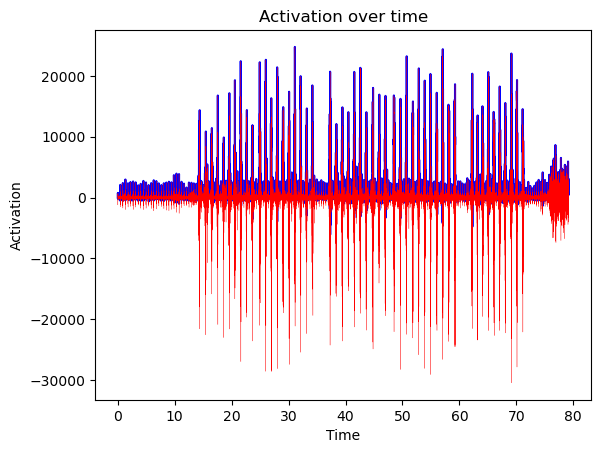

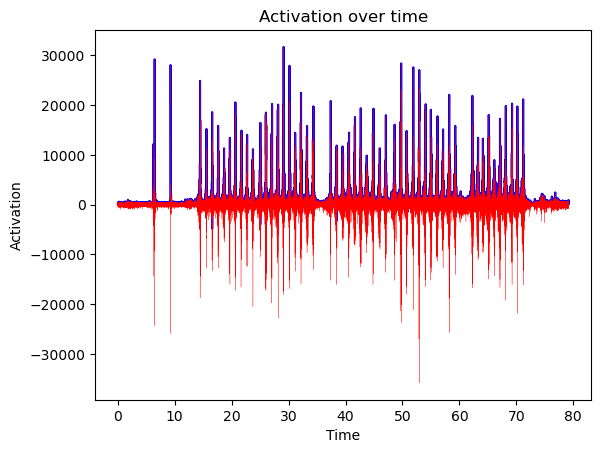

In [2]:
emgFilePath = './data/EMG_data/saffie_hook.txt'#'opensignals_0007804b3c23_2024-09-09_15-04-53.txt'
#--- manuell open (in pipeline)
#Open and reads the file with the EMG data to a long text string and saves it to rawData. Closes the file at the end.
with open(emgFilePath, 'r') as file:     
    rawData = file.read()      
    file.close
    pass        
#---
signalThreshold = 35000
sampleRate = get_sample_rate(rawData)


dataWithHeader = get_emg_data(rawData,sampleRate)
timeAdjustedEmg = find_first_punch(dataWithHeader,signalThreshold) #adjusted data is [time:EMG data Arm, EMG data chest]

emgDataArm = []
emgDataChest = []
timeValues = []
for row in timeAdjustedEmg:
    timeValues.append(row[0])
    emgDataArm.append(row[1])
    emgDataChest.append(row[2])

#filterdSignal = find_first_punch(dataTable, threshold)
lowcut = 20
highcut = 450
adjustedEmgArm = apply_filter(emgDataArm, lowcut, highcut, sampleRate) # adjustedEmg = filteredSignal
adjustedEmgChest = apply_filter(emgDataChest, lowcut, highcut, sampleRate)

window = 10
diffThreashold = 7
envelopeValuesArm,timeValuesEnvelopeArm = envelope_emg(adjustedEmgArm,window,sampleRate)
envelopeValuesChest,timeValuesEnvelopeChest = envelope_emg(adjustedEmgChest,window,sampleRate)
zoomThreshold = 3000


muscleActivationTimeArm = get_muscle_time(envelopeValuesArm,zoomThreshold,window,sampleRate,diffThreashold)
muscleActivationTimeChest = get_muscle_time(envelopeValuesChest,zoomThreshold,window,sampleRate,diffThreashold)
print(muscleActivationTimeArm)
print(muscleActivationTimeChest)
plt.plot(timeValuesEnvelopeArm, envelopeValuesArm, "b")
plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeChest, envelopeValuesChest, "b")
plt.plot(timeValues,adjustedEmgChest, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

In [3]:
#from imu_funcitons import *
import importlib
import imu_functions
from imu_functions import *
print(imu_functions.__file__)

/Users/beatrizfigueiredo/Documents/Project-course-CM2024/imu_functions.py


Number of Punches: 21 -> [124.5026833064025, 125.98492670513116, 111.64241073566811, 101.2406446590562, 125.94763682780894, 125.98492670513116, 107.69472434709716, 125.94763682780894, 102.45196487961314, 125.98492670513116, 125.82475797892397, 125.98492670513116, 125.98492670513116, 125.94763682780894, 125.98492670513116, 125.98492670513116, 125.94901919932357, 125.94901919932357, 125.98492670513116, 125.98492670513116, 101.06610823534479]


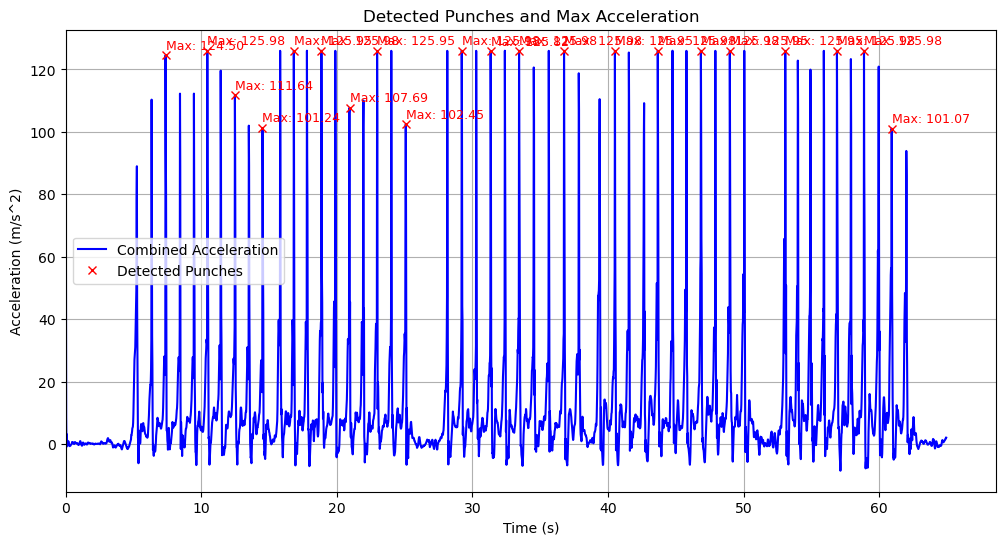

In [7]:
#Set threashold for zacc where timestamp starts, from calibration
threshold=10

g= 9.81 
# Initialize Tkinter root (for file dialog)
root = tk.Tk()
root.withdraw()  # Hide the main Tkinter window

# List to store the timestamps and data
timestampsAcc = []
xAcc = []
yAcc = []
zAcc = []
acc = []

# Read, extract, and process accelerometer data
jsonDataAcc = read_json_file()
timestampsAcc, xAcc, yAcc, zAcc = extract_acc_data(jsonDataAcc)

# Adjust timestamps to start from the first time Z-acceleration exceeds the threshold
adjustedTimestamps = adjust_timestamps_on_first_threshold(timestampsAcc, zAcc, threshold)


# Calculate the acceleration
acc = calculate_acceleration(xAcc, yAcc, zAcc)

# Detect punches and their max accelerations
window_size=20 #if all punches are not showing, it means we have to reduce the window_size
punch_peaks, max_accelerations, peak_timestamps = detect_punches_and_max_acc(adjustedTimestamps, acc, window_size)

# Print max acceleration values as an array for further use
print(f"Number of Punches: {len(max_accelerations)} -> {max_accelerations}")

# # Output the max accelerations and timestamps
# for i, max_acc in enumerate(max_accelerations):
#     print(f"Punch {i+1}: Max Acceleration = {max_acc:.2f} m/s^2 in the time window ({peak_timestamps[i]}s).")


# Plot the punches and max accelerations
plot_punches_with_max_acc(adjustedTimestamps, acc, punch_peaks, max_accelerations, peak_timestamps)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Check if lists have the same length
if len(max_accelerations) != len(muscleActivationTimeArm):
    print("Error: The lists 'max_accelerations' and 'muscleActivationTimeArm' must have the same length.")
else:
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(muscleActivationTimeArm, max_accelerations, color='blue', label='Data points')
    
    # Step 3: Linear regression to find the correlation/equation
    slope, intercept, r_value, p_value, std_err = stats.linregress(muscleActivationTimeArm, max_accelerations)
    
    # Create regression line values
    regression_line = [slope * x + intercept for x in muscleActivationTimeArm]
    
    # Plot the regression line
    plt.plot(muscleActivationTimeArm, regression_line, color='red', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
    
    # Step 4: Customize the plot
    plt.title('Max Accelerations vs Muscle Activation Time Arm')
    plt.xlabel('Muscle Activation Time Arm')
    plt.ylabel('Max Accelerations')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Print correlation info
    print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')
    print(f'Correlation coefficient (R^2): {r_value**2:.2f}')

Error: The lists 'max_accelerations' and 'muscleActivationTimeArm' must have the same length.
